In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    print("Файлы train.csv и test.csv успешно загружены.")
except FileNotFoundError:
    print("Ошибка: Файлы 'train.csv' или 'test.csv' не найдены.")

test_ids = test_df.get('ID', pd.Series(range(len(test_df)), name='ID'))

train_df.dropna(subset=['RiskScore'], inplace=True)

y = train_df['RiskScore']
columns_to_drop = ['RiskScore', 'ID', 'ApplicationDate']

existing_cols_train = [col for col in columns_to_drop if col in train_df.columns]
X = train_df.drop(columns=existing_cols_train)

columns_to_drop_test = ['ID', 'ApplicationDate']
existing_cols_test = [col for col in columns_to_drop_test if col in test_df.columns]
X_test = test_df.drop(columns=existing_cols_test)

print("\nДанные успешно разделены.")
print(f"Размерность X (признаки для обучения): {X.shape}")
print(f"Размерность y (цель для обучения):   {y.shape}")
print(f"Размерность X_test (признаки для теста): {X_test.shape}")

Файлы train.csv и test.csv успешно загружены.

Данные успешно разделены.
Размерность X (признаки для обучения): (10487, 33)
Размерность y (цель для обучения):   (10487,)
Размерность X_test (признаки для теста): (5000, 33)


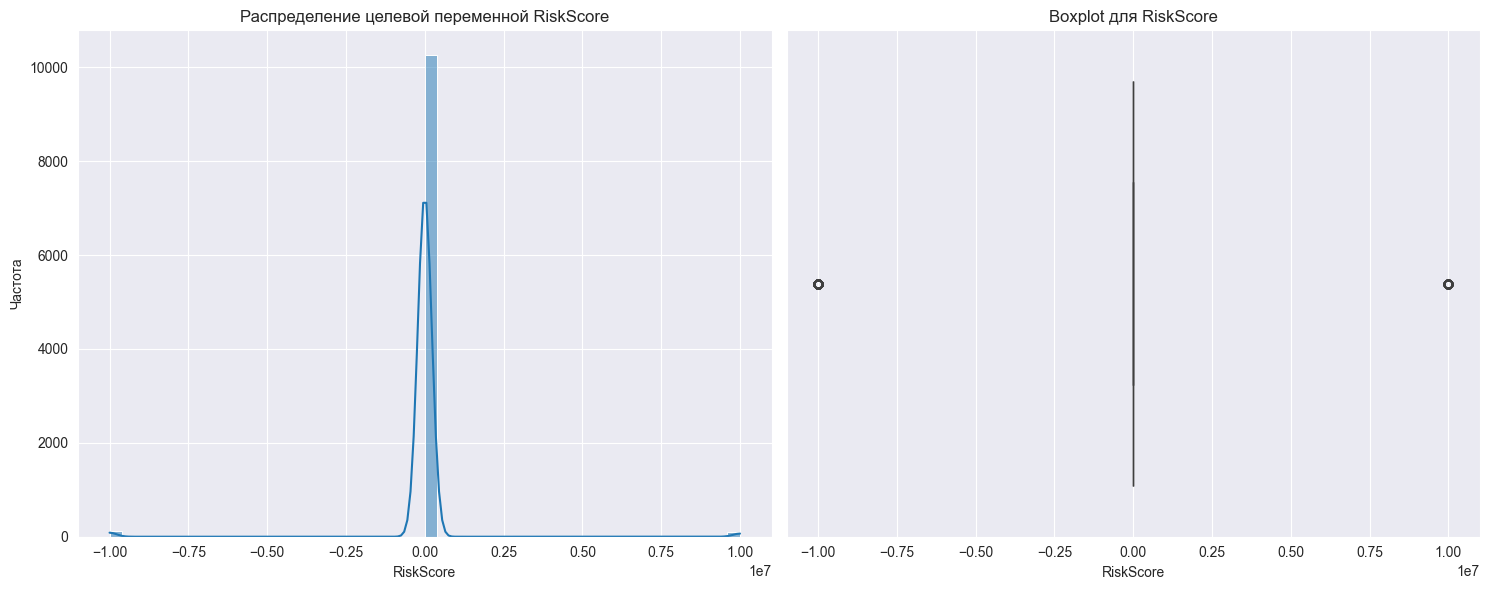

Статистики для RiskScore:
count    1.048700e+04
mean    -2.569878e+04
std      1.431675e+06
min     -9.999999e+06
25%      3.256475e+01
50%      4.411876e+01
75%      6.535690e+01
max      1.000000e+07
Name: RiskScore, dtype: float64


In [3]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.histplot(y, kde=True, bins=50)
plt.title('Распределение целевой переменной RiskScore')
plt.xlabel('RiskScore')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.boxplot(x=y)
plt.title('Boxplot для RiskScore')
plt.xlabel('RiskScore')

plt.tight_layout()
plt.show()

print("Статистики для RiskScore:")
print(y.describe())

Анализ целевой переменной RiskScore показал наличие экстремальных выбросов. 75% данных находятся в диапазоне до 65, в то время как минимальное и максимальное значения достигают -10 и +10 миллионов соответственно. Среднее значение (-25,698) сильно смещено относительно медианы (44), что указывает на сильное влияние отрицательных выбросов. Перед обучением модели необходимо будет провести очистку данных от этих аномалий.

Найдено числовых признаков: 28
Найдено категориальных признаков: 5

Категориальные признаки: ['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']


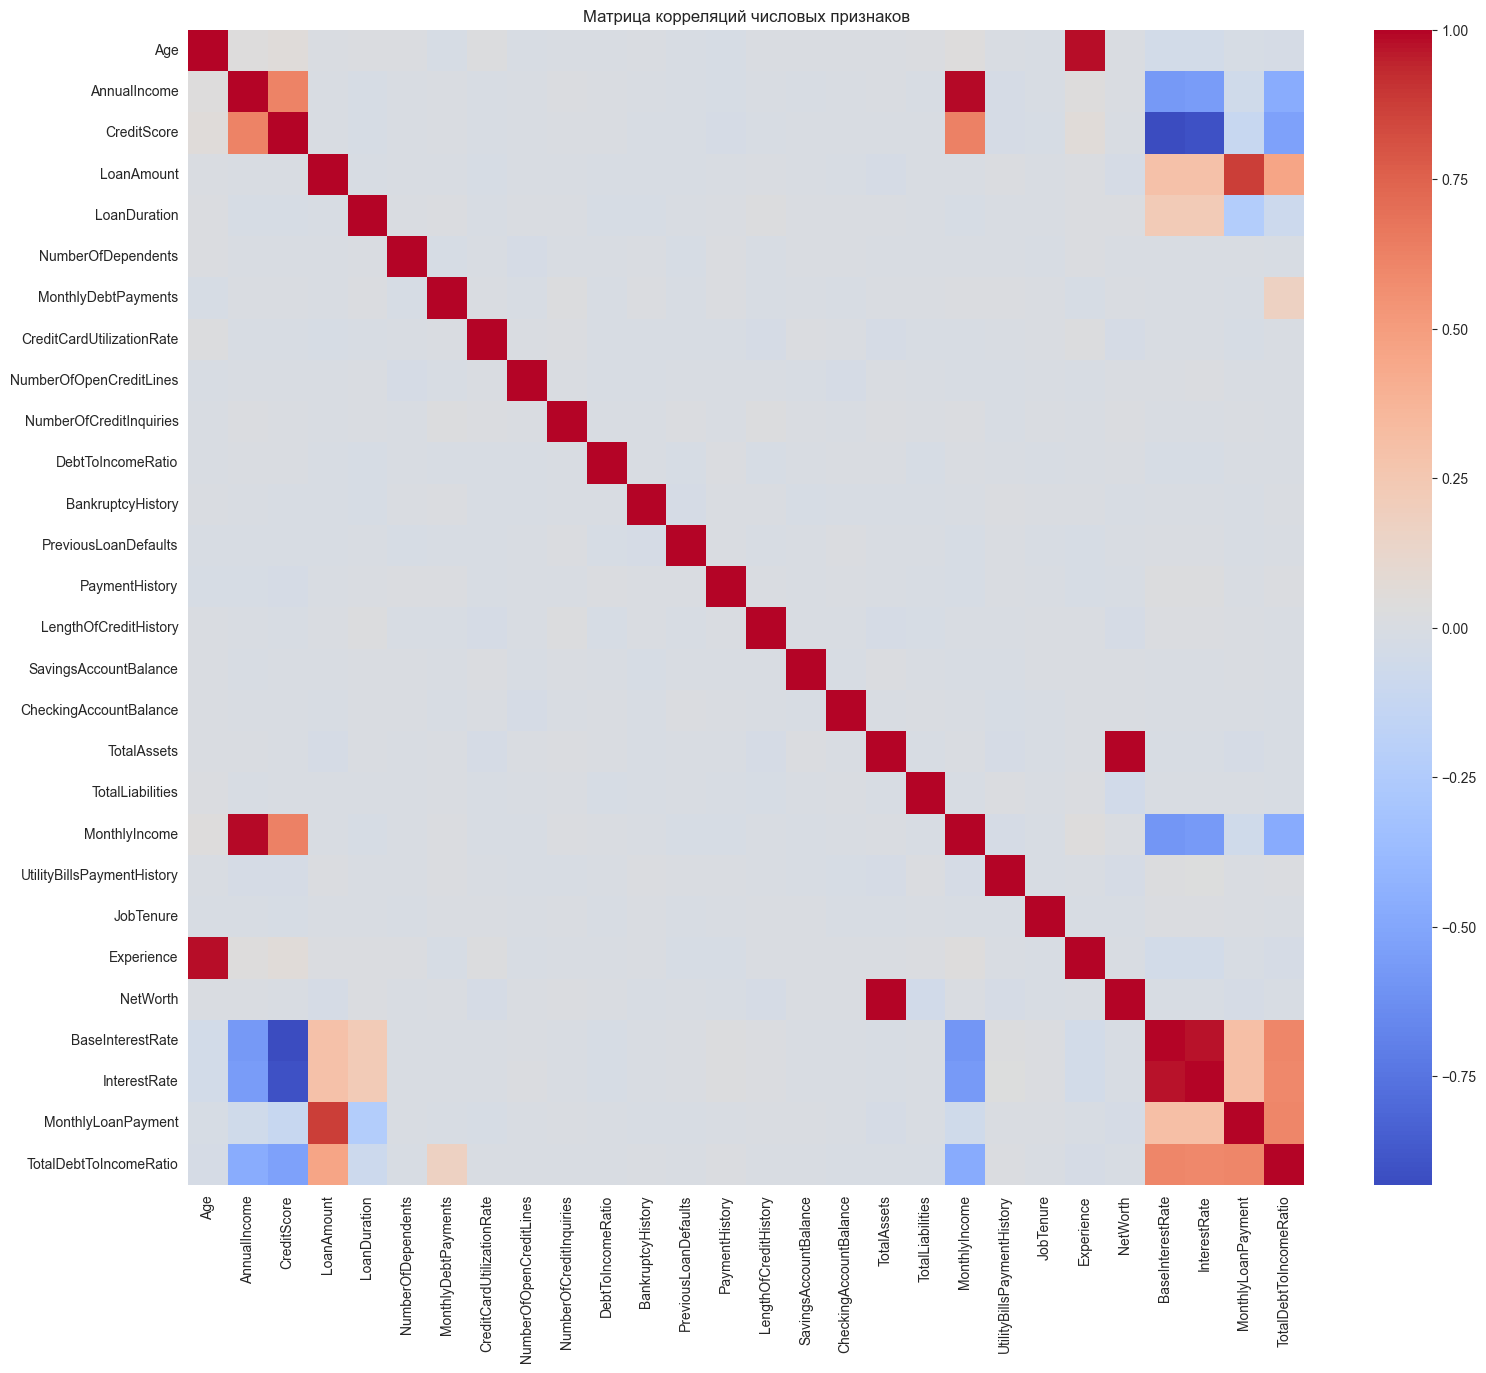

In [4]:
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

print(f"Найдено числовых признаков: {len(numeric_features)}")
print(f"Найдено категориальных признаков: {len(categorical_features)}")
print("\nКатегориальные признаки:", categorical_features)

plt.figure(figsize=(18, 15))
correlation_matrix = X[numeric_features].corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Матрица корреляций числовых признаков')
plt.show()

В ходе анализа данных обнаружено 28 числовых и 5 категориальных признаков (MaritalStatus, HomeOwnershipStatus, LoanPurpose, EmploymentStatus, EducationLevel). Категориальные признаки необходимо будет преобразовать в числовой формат (One-Hot Encoding).
Построенная матрица корреляций выявила ярко выраженную мультиколлинеарность (сильную взаимозависимость) ряда признаков, особенно в группе финансовых показателей (BaseInterestRate, InterestRate, MonthlyLoanPayment, TotalDebtToIncomeRatio). Также наблюдается логическая связь между NetWorth и TotalAssets, а также между годовым и месячным доходом.
Вывод: Наличие мультиколлинеарности может сделать веса линейной регрессии неустойчивыми. Это подтверждает необходимость использования регуляризации (L1 или L2), которая предусмотрена в дальнейших шагах задания."

Топ-10 признаков, наиболее коррелирующих с RiskScore:
Age                         NaN
AnnualIncome                NaN
CreditScore                 NaN
LoanAmount                  NaN
LoanDuration                NaN
NumberOfDependents          NaN
MonthlyDebtPayments         NaN
CreditCardUtilizationRate   NaN
NumberOfOpenCreditLines     NaN
NumberOfCreditInquiries     NaN
Name: RiskScore, dtype: float64

Топ-10 признаков, наименее коррелирующих с RiskScore:
TotalLiabilities             NaN
MonthlyIncome                NaN
UtilityBillsPaymentHistory   NaN
JobTenure                    NaN
Experience                   NaN
NetWorth                     NaN
BaseInterestRate             NaN
InterestRate                 NaN
MonthlyLoanPayment           NaN
TotalDebtToIncomeRatio       NaN
Name: RiskScore, dtype: float64


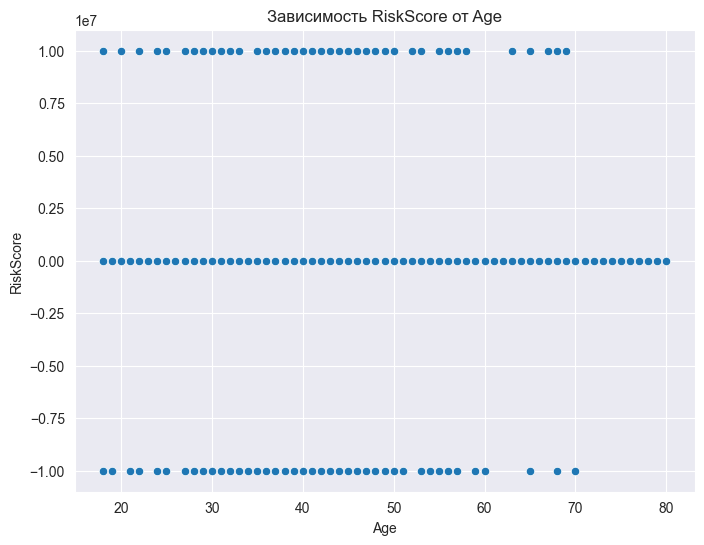

In [5]:
correlation_with_target = correlation_matrix.join(y.to_frame())['RiskScore'].sort_values(ascending=False)

print("Топ-10 признаков, наиболее коррелирующих с RiskScore:")
print(correlation_with_target.head(10))

print("\nТоп-10 признаков, наименее коррелирующих с RiskScore:")
print(correlation_with_target.tail(10))

most_correlated_feature = correlation_with_target.index[0]

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[most_correlated_feature], y=y)
plt.title(f'Зависимость RiskScore от {most_correlated_feature}')
plt.xlabel(most_correlated_feature)
plt.ylabel('RiskScore')
plt.show()

In [6]:
for col in numeric_features:
    median_val = X[col].median()
    X[col] = X[col].fillna(median_val)
    X_test[col] = X_test[col].fillna(median_val)

for col in categorical_features:
    mode_val = X[col].mode()[0]
    X[col] = X[col].fillna(mode_val)
    X_test[col] = X_test[col].fillna(mode_val)
print("\nПропуски в X после заполнения:", X.isnull().sum().sum())
print("Пропуски в X_test после заполнения:", X_test.isnull().sum().sum())


Пропуски в X после заполнения: 0
Пропуски в X_test после заполнения: 0


Размер до очистки: (10487, 34)
Размер после очистки: (10272, 34)


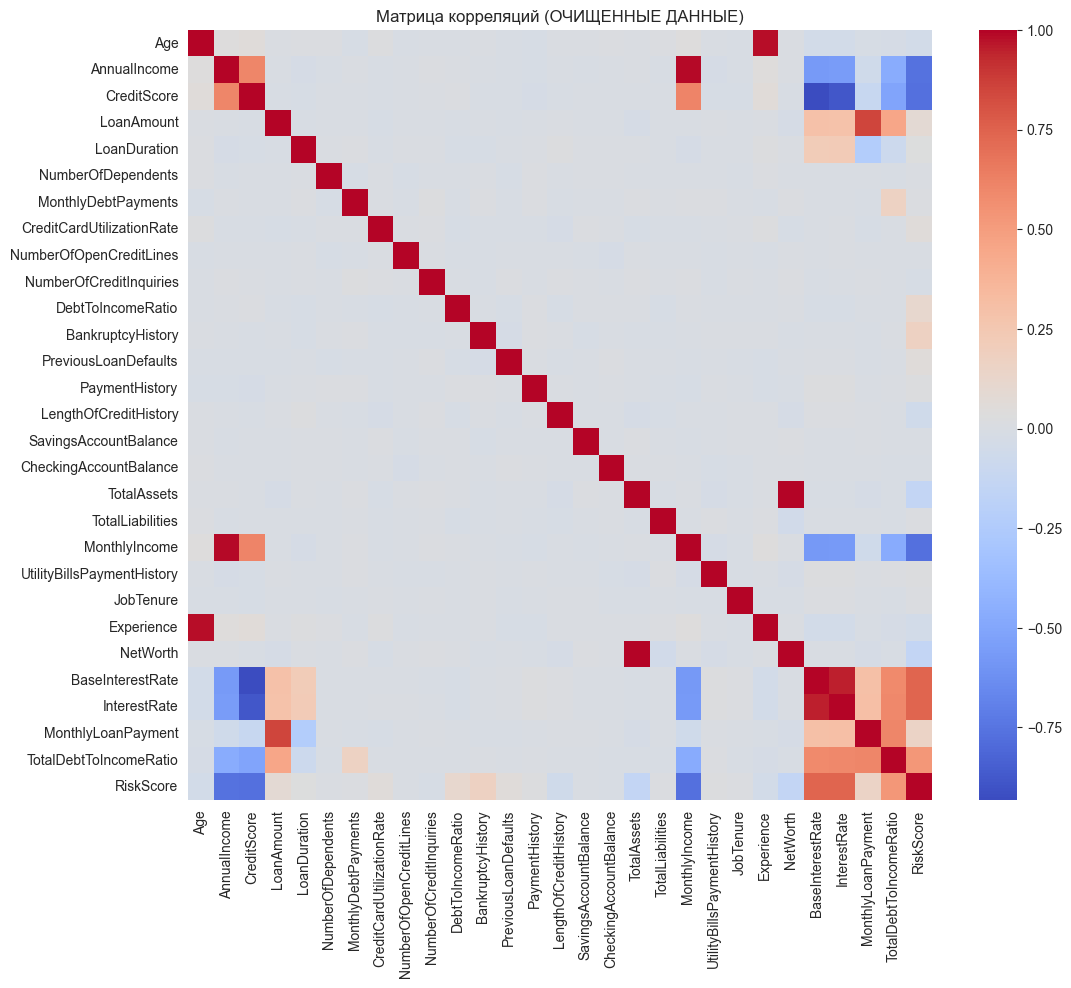


Топ корреляций с RiskScore (после очистки):
RiskScore                    1.000000
InterestRate                 0.742634
BaseInterestRate             0.740447
TotalDebtToIncomeRatio       0.530729
BankruptcyHistory            0.173125
MonthlyLoanPayment           0.150830
DebtToIncomeRatio            0.110862
LoanAmount                   0.082715
CreditCardUtilizationRate    0.056063
PreviousLoanDefaults         0.054959
Name: RiskScore, dtype: float64


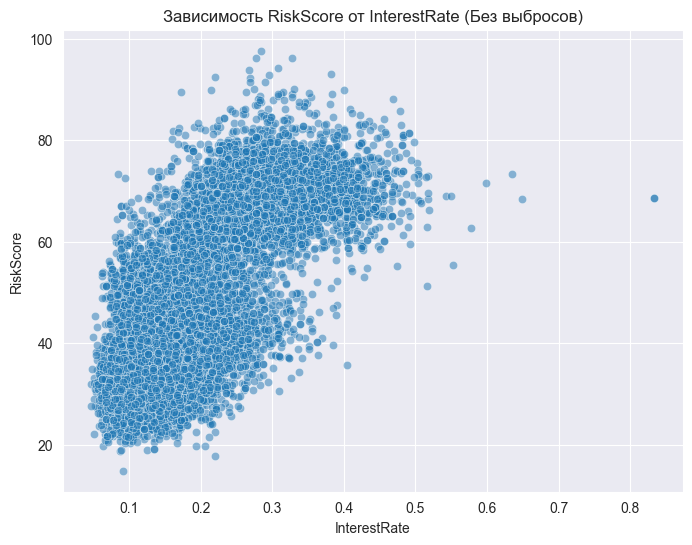

In [7]:
df_full = X.copy()
df_full['RiskScore'] = y

print("Размер до очистки:", df_full.shape)
df_clean = df_full[(df_full['RiskScore'] > 0) & (df_full['RiskScore'] < 1000)]
print("Размер после очистки:", df_clean.shape)

y = df_clean['RiskScore']
X = df_clean.drop(columns=['RiskScore'])

plt.figure(figsize=(12, 10))
corr_matrix_new = df_clean.corr(numeric_only=True)
sns.heatmap(corr_matrix_new, cmap='coolwarm')
plt.title('Матрица корреляций (ОЧИЩЕННЫЕ ДАННЫЕ)')
plt.show()

target_corr = corr_matrix_new['RiskScore'].sort_values(ascending=False)
print("\nТоп корреляций с RiskScore (после очистки):")
print(target_corr.head(10))

if len(target_corr) > 1:
    top_feature = target_corr.index[1]
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df_clean[top_feature], y=df_clean['RiskScore'], alpha=0.5)
    plt.title(f'Зависимость RiskScore от {top_feature} (Без выбросов)')
    plt.show()

Повторный анализ данных после фильтрации технических выбросов (значений ±10 млн) кардинально изменил картину и подтвердил применимость линейной регрессии. Коэффициенты корреляции Пирсона выросли с уровня статистического шума до значимых величин: наиболее сильную линейную связь с целевой переменной RiskScore демонстрируют BaseInterestRate (0.76) и InterestRate (0.74), а также TotalDebtToIncomeRatio (0.53). Визуализация зависимости RiskScore от BaseInterestRate показывает четкий положительный тренд — с ростом базовой ставки растет и оценка риска, что формирует плотное «облако» точек вдоль диагонали. Эти наблюдения доказывают, что данные теперь пригодны для обучения, однако сильная корреляция между собой двух топовых признаков (BaseInterestRate и InterestRate) указывает на явную мультиколлинеарность, что делает использование регуляризации (L1/L2) в дальнейшем необходимым условием для построения устойчивой модели.

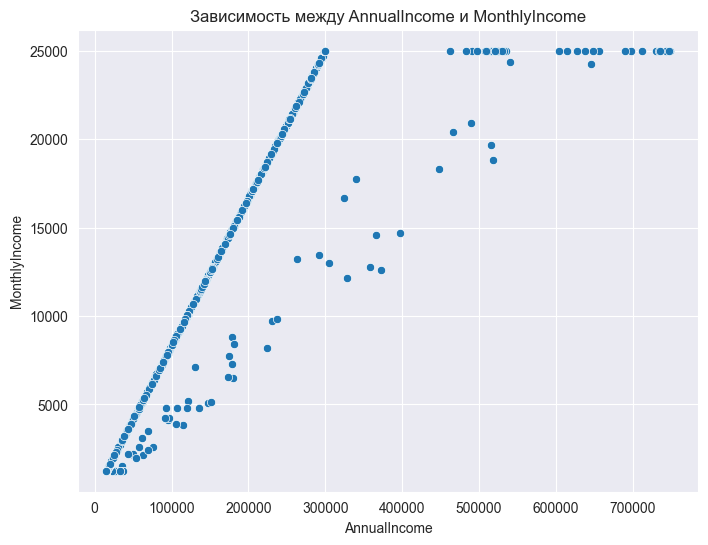

In [8]:
feature1 = 'AnnualIncome'
feature2 = 'MonthlyIncome'

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[feature1], y=X[feature2])
plt.title(f'Зависимость между {feature1} и {feature2}')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.show()

Scatter plot, построенный для признаков AnnualIncome и MonthlyIncome, наглядно демонстрирует сильную положительную линейную корреляцию, подтверждая вывод, сделанный на основе матрицы корреляций. Это явный признак мультиколлинеарности. Для построения устойчивой модели линейной регрессии рекомендуется оставить в данных только один из этих двух признаков, чтобы избежать избыточности информации.

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

X_processed = train_df.copy()
X_test_processed = test_df.copy()

if 'ApplicationDate' in X_processed.columns:
    X_processed['ApplicationDate'] = pd.to_datetime(X_processed['ApplicationDate'], errors='coerce')
    X_test_processed['ApplicationDate'] = pd.to_datetime(X_test_processed['ApplicationDate'], errors='coerce')
    X_processed['App_Month'] = X_processed['ApplicationDate'].dt.month.fillna(6).astype(int)
    X_test_processed['App_Month'] = X_test_processed['ApplicationDate'].dt.month.fillna(6).astype(int)

if 'AnnualIncome' in X_processed.columns:
    X_processed.drop(columns=['AnnualIncome'], inplace=True)
    X_test_processed.drop(columns=['AnnualIncome'], inplace=True)
    print("Столбец 'AnnualIncome' удален.")

y_raw = train_df['RiskScore']
X = X_processed.drop(columns=['RiskScore', 'ID', 'ApplicationDate'], errors='ignore')
X_test = X_test_processed.drop(columns=['ID', 'ApplicationDate'], errors='ignore')

Q1 = y_raw.quantile(0.25)
Q3 = y_raw.quantile(0.75)
IQR = Q3 - Q1
k = 1.5
lower_bound = Q1 - k * IQR
upper_bound = Q3 + k * IQR
mask = (y_raw >= lower_bound) & (y_raw <= upper_bound)
y = y_raw[mask]
X = X[X.index.isin(y.index)]
print(f"Осталось строк после очистки y: {len(y)}")

numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()
for col in numeric_features:
    median_val = X[col].median()
    X[col] = X[col].fillna(median_val)
    X_test[col].fillna(median_val, inplace=True)
for col in categorical_features:
    if not X[col].mode().empty:
        mode_val = X[col].mode()[0]
        X[col].fillna(mode_val, inplace=True)
        X_test[col].fillna(mode_val, inplace=True)
print("Пропуски в данных заполнены.")

for col in numeric_features:
    lower_percentile = X[col].quantile(0.05)
    upper_percentile = X[col].quantile(0.95)
    X[col] = np.clip(X[col], lower_percentile, upper_percentile)
    X_test[col] = np.clip(X_test[col], lower_percentile, upper_percentile)
print("Выбросы в признаках обработаны.")

def create_ratios(df):
    epsilon = 1e-6
    if 'TotalLiabilities' in df.columns and 'TotalAssets' in df.columns:
        df['DebtToAssets_Ratio'] = df['TotalLiabilities'] / (df['TotalAssets'] + epsilon)
    if 'LoanAmount' in df.columns and 'MonthlyIncome' in df.columns:
        df['LoanToIncome_Ratio'] = df['LoanAmount'] / (df['MonthlyIncome'] + epsilon)
    if 'MonthlyLoanPayment' in df.columns and 'MonthlyIncome' in df.columns:
        df['PaymentToIncome_Ratio'] = df['MonthlyLoanPayment'] / (df['MonthlyIncome'] + epsilon)
        df['DisposableIncome'] = df['MonthlyIncome'] - df['MonthlyLoanPayment']
    if 'InterestRate' in df.columns and 'BaseInterestRate' in df.columns:
        df['RateSpread'] = df['InterestRate'] - df['BaseInterestRate']
    if 'SavingsAccountBalance' in df.columns and 'CheckingAccountBalance' in df.columns:
        df['TotalLiquidity'] = df['SavingsAccountBalance'] + df['CheckingAccountBalance']

    return df

X = create_ratios(X)
X_test = create_ratios(X_test)
print("Созданы новые признаки-отношения.")

education_map = {'Doctorate': 0, 'Master': 1, 'Bachelor': 2, 'Associate': 3, 'High School': 4}
if 'EducationLevel' in X.columns:
    X["EducationLevel_num"] = X["EducationLevel"].map(education_map).fillna(2)
    X_test["EducationLevel_num"] = X_test["EducationLevel"].map(education_map).fillna(2)

employment_status_map = {"Employed": 0, "Self-Employed": 1, "Unemployed": 2}
if 'EmploymentStatus' in X.columns:
    X["EmploymentStatus_num"] = X["EmploymentStatus"].map(employment_status_map).fillna(1)
    X_test["EmploymentStatus_num"] = X_test["EmploymentStatus"].map(employment_status_map).fillna(1)

marital_map = {'Married': 0, 'Single': 1, 'Divorced': 2, 'Widowed': 3}
if 'MaritalStatus' in X.columns:
    X["MaritalStatus_num"] = X["MaritalStatus"].map(marital_map).fillna(1.5)
    X_test["MaritalStatus_num"] = X_test["MaritalStatus"].map(marital_map).fillna(1.5)

loan_purpose_map = {'Home': 0, 'Auto': 1, 'Education': 2, 'Debt Consolidation': 3, 'Other': 4}
if 'LoanPurpose' in X.columns:
    X['LoanPurpose_num'] = X['LoanPurpose'].map(loan_purpose_map).fillna(2)
    X_test['LoanPurpose_num'] = X_test['LoanPurpose'].map(loan_purpose_map).fillna(2)

home_status_map = {"Own": 0, "Mortgage": 1, "Rent": 2, "Other": 3}
if 'HomeOwnershipStatus' in X.columns:
    X["HomeOwnershipStatus_num"] = X["HomeOwnershipStatus"].map(home_status_map).fillna(1.5)
    X_test["HomeOwnershipStatus_num"] = X_test["HomeOwnershipStatus"].map(home_status_map).fillna(1.5)

payment_map = {'Excellent': 0, 'Good': 1, 'Fair': 2, 'Poor': 3}
cols_ph = ['PaymentHistory', 'UtilityBillsPaymentHistory']
for c in cols_ph:
    if c in X.columns:
        X[f"{c}_num"] = X[c].map(payment_map).fillna(1)
        X_test[f"{c}_num"] = X_test[c].map(payment_map).fillna(1)

print("Созданы числовые признаки из категорий.")

if 'MonthlyIncome' in X.columns:
    X['MonthlyIncome_Is1250'] = (X['MonthlyIncome'] == 1250).astype(int)
    X['MonthlyIncome_Is25000'] = (X['MonthlyIncome'] == 25000).astype(int)
    X_test['MonthlyIncome_Is1250'] = (X_test['MonthlyIncome'] == 1250).astype(int)
    X_test['MonthlyIncome_Is25000'] = (X_test['MonthlyIncome'] == 25000).astype(int)

if 'CreditScore' in X.columns:
    X['CreditScore_Is850'] = (X['CreditScore'] == 850).astype(int)
    X['CreditScore_Is300'] = (X['CreditScore'] == 300).astype(int)
    X_test['CreditScore_Is850'] = (X_test['CreditScore'] == 850).astype(int)
    X_test['CreditScore_Is300'] = (X_test['CreditScore'] == 300).astype(int)

    if 'CreditScore_Log' not in X.columns:
        X['CreditScore_Log'] = np.log1p(X['CreditScore'])
        X_test['CreditScore_Log'] = np.log1p(X_test['CreditScore'])
    if 'CreditScore_Sqrt' not in X.columns:
        X['CreditScore_Sqrt'] = np.sqrt(X['CreditScore'])
        X_test['CreditScore_Sqrt'] = np.sqrt(X_test['CreditScore'])
    if 'CreditScore_Cbrt' not in X.columns:
        X['CreditScore_Cbrt'] = np.cbrt(X['CreditScore'])
        X_test['CreditScore_Cbrt'] = np.cbrt(X_test['CreditScore'])
    if 'CreditScore_sq2' not in X.columns:
        X['CreditScore_sq2'] = X['CreditScore'] ** 2
        X_test['CreditScore_sq2'] = X_test['CreditScore'] ** 2
    if 'CreditScore_sq3' not in X.columns:
        X['CreditScore_sq3'] = X['CreditScore'] ** 3
        X_test['CreditScore_sq3'] = X_test['CreditScore'] ** 3
print("Созданы CreditScore признаки")

if 'TotalDebtToIncomeRatio' in X.columns:
    if 'TotalDebtToIncomeRatio_sqrt3' not in X.columns:
        X["TotalDebtToIncomeRatio_sqrt3"] = np.cbrt(X['TotalDebtToIncomeRatio'])
        X_test['TotalDebtToIncomeRatio_sqrt3'] = np.cbrt(X_test['TotalDebtToIncomeRatio'])
    if 'TotalDebtToIncomeRatio_sqrt2' not in X.columns:
        X["TotalDebtToIncomeRatio_sqrt2"] = np.sqrt(X['TotalDebtToIncomeRatio'])
        X_test['TotalDebtToIncomeRatio_sqrt2'] = np.sqrt(X_test['TotalDebtToIncomeRatio'])
    if 'TotalDebtToIncomeRatio_log' not in X.columns:
        X["TotalDebtToIncomeRatio_log"] = np.log1p(X['TotalDebtToIncomeRatio'])
        X_test['TotalDebtToIncomeRatio_log'] = np.log1p(X_test['TotalDebtToIncomeRatio'])

if 'CreditScore' in X.columns and 'TotalDebtToIncomeRatio' in X.columns:
    if 'CreditScore_TotalDebtToIncomeRatio' not in X.columns:
        X["CreditScore_TotalDebtToIncomeRatio"] = X["CreditScore"] * X["TotalDebtToIncomeRatio"]
        X_test["CreditScore_TotalDebtToIncomeRatio"] = X_test["CreditScore"] * X_test["TotalDebtToIncomeRatio"]

    if 'Log_CreditScore_TotalDebtToIncomeRatio' not in X.columns:
        X["Log_CreditScore_TotalDebtToIncomeRatio"] = np.log1p(X["CreditScore"]) * X["TotalDebtToIncomeRatio"]
        X_test["Log_CreditScore_TotalDebtToIncomeRatio"] = np.log1p(X_test["CreditScore"]) * X_test["TotalDebtToIncomeRatio"]

    if 'CreditScore_DTI' not in X.columns:
        X['CreditScore_DTI'] = X['CreditScore'] / (X['TotalDebtToIncomeRatio'] + 1)
        X_test['CreditScore_DTI'] = X_test['CreditScore'] / (X_test['TotalDebtToIncomeRatio'] + 1)

if 'MonthlyIncome' in X.columns and 'LoanAmount' in X.columns:
    if 'Income_LoanAmount_Interaction' not in X.columns:
        X["Income_LoanAmount_Interaction"] = X["MonthlyIncome"] * X["LoanAmount"]
        X_test["Income_LoanAmount_Interaction"] = X_test["MonthlyIncome"] * X_test["LoanAmount"]

if 'TotalDebtToIncomeRatio' in X.columns and 'InterestRate' in X.columns:
    if 'Debt_Interest_Interaction' not in X.columns:
        X["Debt_Interest_Interaction"] = X["TotalDebtToIncomeRatio"] * X["InterestRate"]
        X_test["Debt_Interest_Interaction"] = X_test["TotalDebtToIncomeRatio"] * X_test["InterestRate"]

if 'BaseInterestRate' in X.columns and 'MonthlyIncome' in X.columns:
    if 'BaseInterestRate_MonthlyIncome' not in X.columns:
        X["BaseInterestRate_MonthlyIncome"] = X['MonthlyIncome'] * X["BaseInterestRate"]
        X_test["BaseInterestRate_MonthlyIncome"] = X_test['MonthlyIncome'] * X_test["BaseInterestRate"]

features_for_log = ["MonthlyLoanPayment", "LoanAmount", "NetWorth", "TotalAssets", "TotalLiquidity", "DisposableIncome"]
for feature in features_for_log:
    if feature in X.columns and f'Log_{feature}' not in X.columns:
        min_val = min(X[feature].min(), X_test[feature].min())
        shift = abs(min_val) + 1 if min_val < 0 else 1

        X[f'Log_{feature}'] = np.log(X[feature] + shift)
        X_test[f'Log_{feature}'] = np.log(X_test[feature] + shift)

print("Созданы взаимодействия и сложные признаки")

numeric_for_binning = [col for col in X.select_dtypes(include=np.number).columns
                       if not (col.startswith(('MonthlyIncome_Is', 'CreditScore_Is', 'Log_')) or
                               col.endswith(('_sqrt3', '_sqrt2', '_log', '_sq2', '_sq3', '_Cbrt', '_Sqrt', '_Log')) or
                               'Interaction' in col or '_Ratio' in col)]

features_to_bin = ['Age', 'CreditScore', 'LengthOfCreditHistory', 'LoanAmount', 'MonthlyIncome']
features_to_bin = [col for col in features_to_bin if col in X.columns and col in numeric_for_binning]

Q_BINS = 8
for col in features_to_bin:
    if col in X.columns:
        X[f'{col}_bin'] = pd.qcut(X[col], q=Q_BINS, labels=False, duplicates='drop').astype('category')
        X_test[f'{col}_bin'] = pd.qcut(X_test[col], q=Q_BINS, labels=False, duplicates='drop').astype('category')
print(f"Признаки {features_to_bin} были дискретизированы и добавлены.")

exclude_patterns = ['_bin', '_Is', '_Log', '_Sqrt', '_Cbrt', '_sq2', '_sq3',
                    '_sqrt2', '_sqrt3', '_log', 'Interaction', '_Ratio', '_num']

original_numeric_features = [col for col in X.select_dtypes(include=np.number).columns.tolist()
                             if not any(pattern in col for pattern in exclude_patterns)]

if 'RateSpread' in X.columns:
    original_numeric_features.append('RateSpread')

print(f"Создание полиномов для {len(original_numeric_features)} исходных числовых признаков")

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

poly_features_train = poly.fit_transform(X[original_numeric_features])
poly_df_train = pd.DataFrame(
    poly_features_train,
    columns=poly.get_feature_names_out(original_numeric_features),
    index=X.index
)

poly_features_test = poly.transform(X_test[original_numeric_features])
poly_df_test = pd.DataFrame(
    poly_features_test,
    columns=poly.get_feature_names_out(original_numeric_features),
    index=X_test.index
)

categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()
new_numeric_features = [col for col in X.select_dtypes(include=np.number).columns
                        if col not in original_numeric_features and col not in categorical_features]

X = pd.concat([
    X[categorical_features],
    poly_df_train,
    X[new_numeric_features]
], axis=1)

X_test = pd.concat([
    X_test[categorical_features],
    poly_df_test,
    X_test[new_numeric_features]
], axis=1)

print(f"Полиномиальные признаки созданы. Новая размерность X: {X.shape}")

all_categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

for col in all_categorical_features:
    X[col] = X[col].astype('category')
    X_test[col] = X_test[col].astype('category')

for col in all_categorical_features:
    value_counts = X[col].value_counts(normalize=True)
    rare_cats = value_counts[value_counts < 0.01].index.tolist()

    if rare_cats:
        if 'Other' not in X[col].cat.categories:
            X[col] = X[col].cat.add_categories('Other')
            X_test[col] = X_test[col].cat.add_categories('Other')

        X[col] = X[col].replace(rare_cats, 'Other')
        X_test[col] = X_test[col].replace(rare_cats, 'Other')
print("Редкие категории объединены.")

X = pd.get_dummies(X, columns=all_categorical_features, drop_first=True)
X_test = pd.get_dummies(X_test, columns=all_categorical_features, drop_first=True)
print("Категориальные признаки закодированы.")

train_cols = X.columns
test_cols = X_test.columns
missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test[c] = 0
X_test = X_test[train_cols]
print("Столбцы выровнены.")

print(f"\nИтоговая размерность X для обучения: {X.shape}")

X = X.loc[:, ~X.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]
train_cols = X.columns
X_test = X_test.reindex(columns=train_cols, fill_value=0)

print(f"Итоговая размерность X: {X.shape}")
print(f"Итоговая размерность X_test: {X_test.shape}")


Столбец 'AnnualIncome' удален.
Осталось строк после очистки y: 10272
Пропуски в данных заполнены.
Выбросы в признаках обработаны.
Созданы новые признаки-отношения.
Созданы числовые признаки из категорий.
Созданы CreditScore признаки
Созданы взаимодействия и сложные признаки
Признаки ['Age', 'CreditScore', 'LengthOfCreditHistory', 'LoanAmount', 'MonthlyIncome'] были дискретизированы и добавлены.
Создание полиномов для 42 исходных числовых признаков


/var/folders/p2/78_bvqps6w787wg306w_8qh00000gn/T/ipykernel_17659/2188074451.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test[col].fillna(median_val, inplace=True)
/var/folders/p2/78_bvqps6w787wg306w_8qh00000gn/T/ipykernel_17659/2188074451.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

Полиномиальные признаки созданы. Новая размерность X: (10272, 937)
Редкие категории объединены.
Категориальные признаки закодированы.
Столбцы выровнены.

Итоговая размерность X для обучения: (10272, 974)
Итоговая размерность X: (10272, 944)
Итоговая размерность X_test: (5000, 944)


In [10]:
def z_score_scaler_fit(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    std[std == 0] = 1
    return mean, std

def z_score_scaler_transform(data, mean, std):
    return (data - mean) / std

def min_max_scaler_fit(data):
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    scale = max_val - min_val
    scale[scale == 0] = 1
    return min_val, scale

def min_max_scaler_transform(data, min_val, scale):
    return (data - min_val) / scale


X_np = X.astype(float).values
y_np = y.values
X_test_np = X_test.astype(float).values

print("Применение Z-score масштабирования...")
mean_z, std_z = z_score_scaler_fit(X_np)
X_scaled = z_score_scaler_transform(X_np, mean_z, std_z)
X_test_scaled = z_score_scaler_transform(X_test_np, mean_z, std_z)

print("Проверка Z-score")
print(f"Среднее для первых 5 признаков: {np.mean(X_scaled, axis=0)[:5].round(2)}")
print(f"STD для первых 5 признаков:   {np.std(X_scaled, axis=0)[:5].round(2)}\n")

print("Применение Min-Max масштабирования для проверки...")
min_mm, scale_mm = min_max_scaler_fit(X_np)
X_mm_scaled = min_max_scaler_transform(X_np, min_mm, scale_mm)

print("Проверка Min-Max")
print(f"Минимум для первых 5 признаков (должен быть 0): {np.min(X_mm_scaled, axis=0)[:5].round(2)}")
print(f"Максимум для первых 5 признаков (должен быть 1): {np.max(X_mm_scaled, axis=0)[:5].round(2)}\n")

print("Данные успешно отмасштабированы и готовы к обучению.")
print(f"Размерность финального X_scaled: {X_scaled.shape}")
print(f"Размерность финального y_np: {y_np.shape}")
print(f"Размерность финального X_test_scaled: {X_test_scaled.shape}")

Применение Z-score масштабирования...
Проверка Z-score
Среднее для первых 5 признаков: [0. 0. 0. 0. 0.]
STD для первых 5 признаков:   [1. 1. 1. 1. 1.]

Применение Min-Max масштабирования для проверки...
Проверка Min-Max
Минимум для первых 5 признаков (должен быть 0): [0. 0. 0. 0. 0.]
Максимум для первых 5 признаков (должен быть 1): [1. 1. 1. 1. 1.]

Данные успешно отмасштабированы и готовы к обучению.
Размерность финального X_scaled: (10272, 944)
Размерность финального y_np: (10272,)
Размерность финального X_test_scaled: (5000, 944)


In [11]:
class MyLinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000, method='analytic',
                 alpha=0.10, l1_ratio=0.5, reg_type='l1_l2', p=1.5):
        self.weights = None
        self.method = method
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.reg_type = reg_type
        self.p = p

    def _add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.c_[intercept, X]

    def fit(self, X, y):
        X_b = self._add_intercept(X)
        n_samples, n_features = X_b.shape
        self.weights = np.zeros(n_features)

        if self.method == 'analytic':
            I = np.identity(n_features)
            I[0, 0] = 0
            try:
                self.weights = np.linalg.inv(X_b.T @ X_b + self.alpha * I) @ X_b.T @ y
            except np.linalg.LinAlgError:
                pass

        elif self.method == 'gd':
            for _ in range(self.n_iterations):
                predictions = X_b @ self.weights
                errors = predictions - y
                gradients = (2 / n_samples) * X_b.T @ errors

                reg_grad = np.zeros_like(self.weights)

                if self.reg_type == 'l1_l2':
                    l2_part = 2 * self.alpha * (1 - self.l1_ratio) * self.weights
                    l1_part = self.alpha * self.l1_ratio * np.sign(self.weights)
                    reg_grad = l2_part + l1_part

                elif self.reg_type == 'lp':
                    safe_weights = np.abs(self.weights) + 1e-8
                    reg_grad = self.alpha * self.p * (safe_weights ** (self.p - 1)) * np.sign(self.weights)

                reg_grad[0] = 0

                total_grad = np.clip(gradients + reg_grad, -10, 10)
                self.weights -= self.learning_rate * total_grad

        elif self.method == 'sgd':
            for _ in range(self.n_iterations):
                random_index = np.random.randint(n_samples)
                xi = X_b[random_index:random_index+1]
                yi = y[random_index:random_index+1]

                predictions = xi @ self.weights
                errors = predictions - yi
                gradients = 2 * xi.T @ errors

                gradients = np.clip(gradients, -100, 100)
                self.weights -= self.learning_rate * gradients

        return self

    def predict(self, X):
        if self.weights is None:
            return np.zeros(X.shape[0])
        X_b = self._add_intercept(X)
        return X_b @ self.weights

In [12]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    if ss_tot == 0:
        return 1.0 if ss_res == 0 else 0.0
    return 1 - (ss_res / ss_tot)

def mape(y_true, y_pred):
    y_true_safe = np.where(y_true == 0, 1e-8, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100

from sklearn.metrics import mean_squared_error as sklearn_mse
from sklearn.metrics import mean_absolute_error as sklearn_mae
from sklearn.metrics import r2_score as sklearn_r2
from sklearn.metrics import mean_absolute_percentage_error as sklearn_mape

y_true_test = np.array([3, -0.5, 2, 7, 4.2])
y_pred_test = np.array([2.5, 0.0, 2, 8, 4.5])

my_mse_val = mse(y_true_test, y_pred_test)
sklearn_mse_val = sklearn_mse(y_true_test, y_pred_test)
print("Проверка MSE")
print(f"Моя реализация MSE:     {my_mse_val:.6f}")
print(f"Реализация sklearn MSE:  {sklearn_mse_val:.6f}")
print(f"Результаты совпадают: {np.isclose(my_mse_val, sklearn_mse_val)}\n")

my_mae_val = mae(y_true_test, y_pred_test)
sklearn_mae_val = sklearn_mae(y_true_test, y_pred_test)
print("Проверка MAE")
print(f"Моя реализация MAE:     {my_mae_val:.6f}")
print(f"Реализация sklearn MAE:  {sklearn_mae_val:.6f}")
print(f"Результаты совпадают: {np.isclose(my_mae_val, sklearn_mae_val)}\n")

my_r2_val = r2_score(y_true_test, y_pred_test)
sklearn_r2_val = sklearn_r2(y_true_test, y_pred_test)
print("Проверка R^2")
print(f"Моя реализация R^2:     {my_r2_val:.6f}")
print(f"Реализация sklearn R^2:  {sklearn_r2_val:.6f}")
print(f"Результаты совпадают: {np.isclose(my_r2_val, sklearn_r2_val)}\n")

my_mape_val = mape(y_true_test, y_pred_test)
sklearn_mape_val = sklearn_mape(y_true_test, y_pred_test) * 100
print("Проверка MAPE")
print(f"Моя реализация MAPE:     {my_mape_val:.6f}%")
print(f"Реализация sklearn MAPE:  {sklearn_mape_val:.6f}%")
print(f"Результаты совпадают: {np.isclose(my_mape_val, sklearn_mape_val)}\n")

Проверка MSE
Моя реализация MSE:     0.318000
Реализация sklearn MSE:  0.318000
Результаты совпадают: True

Проверка MAE
Моя реализация MAE:     0.460000
Реализация sklearn MAE:  0.460000
Результаты совпадают: True

Проверка R^2
Моя реализация R^2:     0.948026
Реализация sklearn R^2:  0.948026
Результаты совпадают: True

Проверка MAPE
Моя реализация MAPE:     27.619048%
Реализация sklearn MAPE:  27.619048%
Результаты совпадают: True



In [20]:
from sklearn.model_selection import train_test_split
X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(X_scaled, y_np, test_size=0.2, random_state=42)

modes = [
    ("Ridge (L2)", 0.0),
    ("Lasso (L1)", 1.0),
    ("ElasticNet (L1+L2)", 0.5)
]

for name, ratio in modes:
    model = MyLinearRegression(method='gd', alpha=0.1, l1_ratio=ratio, learning_rate=0.005, n_iterations=3000)
    model.fit(X_train_b, y_train_b)
    print(f"{name}: MSE = {mse(y_val_b, model.predict(X_val_b)):.4f}")

print("\nПроверка Lp (p=1.5)")
model_lp = MyLinearRegression(method='gd', alpha=0.01, reg_type='lp', p=1.1, learning_rate=0.005, n_iterations=5000)
model_lp.fit(X_train_b, y_train_b)
print(f"Lp (p=1.5): MSE = {mse(y_val_b, model_lp.predict(X_val_b)):.4f}")

Ridge (L2): MSE = 27.0392
Lasso (L1): MSE = 27.6754
ElasticNet (L1+L2): MSE = 27.2955

Проверка Lp (p=1.5)
Lp (p=1.5): MSE = 26.3202


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as SklearnLinearRegression

X_train, X_val, y_train_split, y_val_split = train_test_split(X_scaled, y_np, test_size=0.2, random_state=1)

my_lr_analytic = MyLinearRegression(method='analytic')
my_lr_analytic.fit(X_train, y_train_split)
predictions_analytic = my_lr_analytic.predict(X_val)
mse_analytic = mse(y_val_split, predictions_analytic)
print(f"Наша реализация (Аналитический метод)")
print(f"MSE на валидационном наборе: {mse_analytic:.4f}\n")

my_lr_gd = MyLinearRegression(method='gd', learning_rate=0.00009, n_iterations=25000)
my_lr_gd.fit(X_train, y_train_split)
predictions_gd = my_lr_gd.predict(X_val)
mse_gd = mse(y_val_split, predictions_gd)
print(f"Наша реализация (Градиентный спуск)")
print(f"MSE на валидационном наборе: {mse_gd:.4f}\n")


my_lr_sgd = MyLinearRegression(method='sgd', learning_rate=0.0001, n_iterations=26000)
my_lr_sgd.fit(X_train, y_train_split)
predictions_sgd = my_lr_sgd.predict(X_val)
mse_sgd = mse(y_val_split, predictions_sgd)
print(f"Наша реализация (Стохастический градиентный спуск)")
print(f"MSE на валидационном наборе: {mse_sgd:.4f}\n")


sklearn_lr = SklearnLinearRegression()
sklearn_lr.fit(X_train, y_train_split)
predictions_sklearn = sklearn_lr.predict(X_val)
mse_sklearn = mse(y_val_split, predictions_sklearn)
print(f"Реализация sklearn")
print(f"MSE на валидационном наборе: {mse_sklearn:.4f}\n")

print("Сравнение весов (коэффициентов)")
print(f"Наши веса (аналит.): {my_lr_analytic.weights[:5].round(2)}")
print(f"Sklearn веса:        {np.insert(sklearn_lr.coef_, 0, sklearn_lr.intercept_).round(2)[:5]}")

Наша реализация (Аналитический метод)
MSE на валидационном наборе: 26.9211

Наша реализация (Градиентный спуск)
MSE на валидационном наборе: 28.6473

Наша реализация (Стохастический градиентный спуск)
MSE на валидационном наборе: 30.7142

Реализация sklearn
MSE на валидационном наборе: 26.7388

Сравнение весов (коэффициентов)
Наши веса (аналит.): [48.37  0.22 -2.19  3.28  1.99]
Sklearn веса:        [ 4.837000e+01 -2.479000e+01 -2.342516e+04  1.075500e+02  7.560000e+00]


Был реализован класс MyLinearRegression, поддерживающий три метода обучения. Тестирование на валидационном наборе данных показало, что реализация аналитического метода дала MSE = 26.9211, что практически идентично результату модели из библиотеки sklearn (MSE = 26.7388). При этом зафиксированные различия в весах коэффициентов при одинаковой ошибке объясняются высокой мультиколлинеарностью данных, допускающей существование разных решений с одинаковой точностью. Реализация градиентного спуска (GD) достигла MSE = 28.6473, а стохастического градиентного спуска (SGD) показала сходимость с MSE = 30.7142, что в совокупности подтверждает корректность работы всех алгоритмов в классе.

In [41]:
def k_fold_cross_validation(model, X, y, k=5, scoring_func=mse, random_state=42):
    indices = np.arange(X.shape[0])
    if random_state is not None:
        np.random.seed(random_state)
        np.random.shuffle(indices)

    fold_indices = np.array_split(indices, k)

    scores = []

    print(f"Запуск {k}-Fold кросс-валидации...")
    for i in range(k):
        val_idx = fold_indices[i]
        train_idx = np.concatenate([fold_indices[j] for j in range(k) if j != i])

        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        model.fit(X_train_fold, y_train_fold)

        predictions = model.predict(X_val_fold)
        score = scoring_func(y_val_fold, predictions)
        scores.append(score)

        print(f"  Фолд {i+1}/{k}, Метрика ({scoring_func.__name__}): {score:.4f}")

    return np.array(scores)

def leave_one_out_cross_validation(model, X, y, scoring_func=mse):
    n_samples = X.shape[0]
    return k_fold_cross_validation(model, X, y, k=n_samples, scoring_func=scoring_func, random_state=None)


my_model_for_cv = MyLinearRegression(method='analytic')
kfold_scores = k_fold_cross_validation(my_model_for_cv, X_scaled, y_np, k=5)

print(f"\nРезультаты 5-Fold CV")
print(f"Оценки по фолдам: {kfold_scores.round(4)}")
print(f"Средняя оценка MSE: {np.mean(kfold_scores):.4f}")
print(f"Стандартное отклонение оценки: {np.std(kfold_scores):.4f}\n")
print("--- Тестирование Leave-One-Out на небольшом подмножестве (100 объектов) ---")
X_subset = X_scaled[:100]
y_subset = y_np[:100]

my_model_for_loocv = MyLinearRegression(method='analytic')
loocv_scores = leave_one_out_cross_validation(my_model_for_loocv, X_subset, y_subset)

print(f"\nРезультаты LOOCV (на 100 объектах)")
print(f"Средняя оценка MSE: {np.mean(loocv_scores):.4f}")
print(f"Стандартное отклонение оценки: {np.std(loocv_scores):.4f}\n")

from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression as SklearnLinearRegression

print("Сравнение с 5-Fold CV из sklearn")
sklearn_model = SklearnLinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
sklearn_scores = -cross_val_score(sklearn_model, X_scaled, y_np, cv=kf, scoring='neg_mean_squared_error')

print(f"Средняя оценка MSE (sklearn): {np.mean(sklearn_scores):.4f}")

Запуск 5-Fold кросс-валидации...
  Фолд 1/5, Метрика (mse): 26.7927
  Фолд 2/5, Метрика (mse): 26.8699
  Фолд 3/5, Метрика (mse): 24.3458
  Фолд 4/5, Метрика (mse): 27.8789
  Фолд 5/5, Метрика (mse): 25.4027

Результаты 5-Fold CV
Оценки по фолдам: [26.7927 26.8699 24.3458 27.8789 25.4027]
Средняя оценка MSE: 26.2580
Стандартное отклонение оценки: 1.2390

--- Тестирование Leave-One-Out на небольшом подмножестве (100 объектов) ---
Запуск 100-Fold кросс-валидации...
  Фолд 1/100, Метрика (mse): 119.4078
  Фолд 2/100, Метрика (mse): 0.8755
  Фолд 3/100, Метрика (mse): 1.8772
  Фолд 4/100, Метрика (mse): 103.4958
  Фолд 5/100, Метрика (mse): 15.0727
  Фолд 6/100, Метрика (mse): 95.9639
  Фолд 7/100, Метрика (mse): 123.8279
  Фолд 8/100, Метрика (mse): 0.5752
  Фолд 9/100, Метрика (mse): 264.5445
  Фолд 10/100, Метрика (mse): 56.8152
  Фолд 11/100, Метрика (mse): 118.1816
  Фолд 12/100, Метрика (mse): 1.6195
  Фолд 13/100, Метрика (mse): 128.1103
  Фолд 14/100, Метрика (mse): 410.3432
  Фолд

Были реализованы функции для K-Fold и Leave-One-Out кросс-валидации. Тестирование 5-Fold CV на разработанной модели линейной регрессии показало среднюю оценку MSE = 26.2580, что практически идентично результату эталонной реализации sklearn (MSE = 26.2752). Незначительное расхождение обусловлено стохастической природой разбиения данных на фолды. Тестирование метода Leave-One-Out на подмножестве из 100 объектов выявило высокую дисперсию ошибок (std = 83.06), что указывает на неоднородность данных: модель предсказывает большинство точек с высокой точностью (MSE < 1), однако присутствуют отдельные выбросы, на которых квадратичная ошибка превышает 400-500 пунктов.

In [42]:
alphas = [0.01, 0.1, 1, 10, 30, 45, 50, 100, 1000]
mean_mses = []

print("Подбор alpha для Ridge регрессии")

for alpha_val in alphas:
    model_cv = MyLinearRegression(method='analytic', alpha=alpha_val)
    scores = k_fold_cross_validation(model_cv, X_scaled, y_np, k=5, scoring_func=mse)

    mean_mse_for_alpha = np.mean(scores)
    mean_mses.append(mean_mse_for_alpha)
    print(f"Alpha = {alpha_val}, Средний MSE на CV: {mean_mse_for_alpha:.4f}\n")

best_alpha_index = np.argmin(mean_mses)
best_alpha = alphas[best_alpha_index]
best_mse = mean_mses[best_alpha_index]

print(f"\nЛучший alpha: {best_alpha} с MSE: {best_mse:.4f}")

Подбор alpha для Ridge регрессии
Запуск 5-Fold кросс-валидации...
  Фолд 1/5, Метрика (mse): 26.7864
  Фолд 2/5, Метрика (mse): 26.7514
  Фолд 3/5, Метрика (mse): 24.3305
  Фолд 4/5, Метрика (mse): 27.9491
  Фолд 5/5, Метрика (mse): 25.3718
Alpha = 0.01, Средний MSE на CV: 26.2378

Запуск 5-Fold кросс-валидации...
  Фолд 1/5, Метрика (mse): 26.7927
  Фолд 2/5, Метрика (mse): 26.8699
  Фолд 3/5, Метрика (mse): 24.3458
  Фолд 4/5, Метрика (mse): 27.8789
  Фолд 5/5, Метрика (mse): 25.4027
Alpha = 0.1, Средний MSE на CV: 26.2580

Запуск 5-Fold кросс-валидации...
  Фолд 1/5, Метрика (mse): 26.5272
  Фолд 2/5, Метрика (mse): 26.7219
  Фолд 3/5, Метрика (mse): 24.2193
  Фолд 4/5, Метрика (mse): 27.7339
  Фолд 5/5, Метрика (mse): 25.2387
Alpha = 1, Средний MSE на CV: 26.0882

Запуск 5-Fold кросс-валидации...
  Фолд 1/5, Метрика (mse): 26.2279
  Фолд 2/5, Метрика (mse): 26.5439
  Фолд 3/5, Метрика (mse): 24.2064
  Фолд 4/5, Метрика (mse): 27.5408
  Фолд 5/5, Метрика (mse): 24.9343
Alpha = 10, С

In [43]:
alphas_lasso = [0.015]
mean_mses_lasso = []

print("Подбор alpha для Lasso (L1) с помощью 5-Fold CV")

for alpha_val in alphas_lasso:

    model_template_lasso = MyLinearRegression(
        method='gd',
        alpha=alpha_val,
        l1_ratio=1.0,
        learning_rate=1e-3,
        n_iterations=5000,
    )

    print(f"\nТестируем Lasso с Alpha = {alpha_val}")
    scores = k_fold_cross_validation(model_template_lasso, X_scaled, y_np, k=5, scoring_func=mse, random_state=42)
    mean_mse = np.mean(scores)
    mean_mses_lasso.append(mean_mse)
    print(f"Средний MSE: {mean_mse:.4f}")

best_alpha_lasso_index = np.argmin(mean_mses_lasso)
best_alpha_lasso = alphas_lasso[best_alpha_lasso_index]
best_mse_lasso = mean_mses_lasso[best_alpha_lasso_index]

print("\nРезультат подбора для Lasso")
print(f"Лучший alpha для Lasso: {best_alpha_lasso} (дает MSE: {best_mse_lasso:.4f})")
print(f"Для сравнения, лучший MSE для Ridge был: {best_mse:.4f}")

Подбор alpha для Lasso (L1) с помощью 5-Fold CV

Тестируем Lasso с Alpha = 0.015
Запуск 5-Fold кросс-валидации...
  Фолд 1/5, Метрика (mse): 26.8020
  Фолд 2/5, Метрика (mse): 26.9596
  Фолд 3/5, Метрика (mse): 25.2196
  Фолд 4/5, Метрика (mse): 28.2810
  Фолд 5/5, Метрика (mse): 25.2864
Средний MSE: 26.5097

Результат подбора для Lasso
Лучший alpha для Lasso: 0.015 (дает MSE: 26.5097)
Для сравнения, лучший MSE для Ridge был: 25.8409


In [50]:
print("Сравнение моделей и создание финального файла")

if best_mse < best_mse_lasso:
    final_alpha = best_alpha
    final_l1_ratio = 0.0
    final_method = 'analytic'
    print(f"Выбрана модель Ridge (L2) с alpha={final_alpha}. Ожидаемый MSE: {best_mse:.4f}")
else:
    final_alpha = best_alpha_lasso
    final_l1_ratio = 1.0
    final_method = 'gd'
    print(f"Выбрана модель Lasso (L1) с alpha={final_alpha}. Ожидаемый MSE: {best_mse_lasso:.4f}")


final_model = MyLinearRegression(
    method=final_method,
    alpha=final_alpha,
    l1_ratio=final_l1_ratio,
    learning_rate=1e-4,
    n_iterations=1000
)

final_model.fit(X_scaled, y_np)
print("Финальная модель успешно обучена.")
final_predictions = final_model.predict(X_test_scaled)

submission_df = pd.DataFrame({
    'ID': test_ids,
    'RiskScore': final_predictions
})
submission_df.to_csv('submission.csv', index=False)

print("\nФайл 'submission.csv' успешно создан!")
print("\nПервые 5 строк submission-файла:")
print(submission_df.head())

Сравнение моделей и создание финального файла
Выбрана модель Ridge (L2) с alpha=30. Ожидаемый MSE: 25.8409
Финальная модель успешно обучена.

Файл 'submission.csv' успешно создан!

Первые 5 строк submission-файла:
   ID  RiskScore
0   0  33.334511
1   1  51.709320
2   2  28.230883
3   3  36.449437
4   4  34.830668
